### Problem 7 molecular mechanics calculations
Molecular mechanics calculation includes several parameterized interaction terms
- bond stretching
- bond angle bending
- torsion angle rotation
- non-bonded interactions
In this problem with butane molecule, we will calculate the potential energy of the molecule using the following parameters

In [8]:
import math
# C-C/C-H stretching energy
def CC_stretching(l):
    return 1735 * (l - 1.538) ** 2
def CH_stretching(l):
    return 1935 * (l - 1.083) ** 2
# C-C/C-H bending energy
def CC_bending(a):
    return 0.11 * (a - 112.5) ** 2
def CH_bending(a):
    return 0.093 * (a - 110.7) ** 2
# dihedral torsional energy
def torsional(a):
    const = [-4.7,1.91,-7.75,0.58]
    energy = 20.1
    for i in range(len(const)):
        energy += const[i] * (1 + math.cos(math.radians((i + 1) * a)))
    return energy
# non-bonded lennard-jones energy
def lennard_jones(r):
    return 4.7 * ((3.85 / r) ** 12 - (3.85 / r) ** 6)



In [10]:
# Sturcture A
energy_A = torsional(65) + lennard_jones(3.13)
print(f'structure A energy: {energy_A:.2f} kj/mol')
# structure B
energy_B = torsional(0) + lennard_jones(2.749)
print(f'structure B energy: {energy_B:.2f} kj/mol')
# structure C
energy_C = CC_stretching(1.56) + torsional(0) + lennard_jones(2.771)
print(f'structure C energy: {energy_C:.2f} kj/mol')
# structure D
energy_D = CC_stretching(1.61) + torsional(0) + lennard_jones(2.821)
print(f'structure D energy: {energy_D:.2f} kj/mol')

structure A energy: 54.41 kj/mol
structure B energy: 232.34 kj/mol
structure C energy: 210.42 kj/mol
structure D energy: 175.05 kj/mol


### Problem 8 implementing MMFF94 force field
(1) Unstrained hydrocarbons typically have C-C single bond lengths of \~1.54Å and C-C-C
angles of \~110°. Below are some examples of strained hydrocarbons that possess
unusually long C-C bonds and angles. Optimize the geometries using the MMFF force
field and label the atypical bonds and angles with their predicted values.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw,AllChem
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit import ForceField
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor, IPythonConsole
from IPython.display import Image

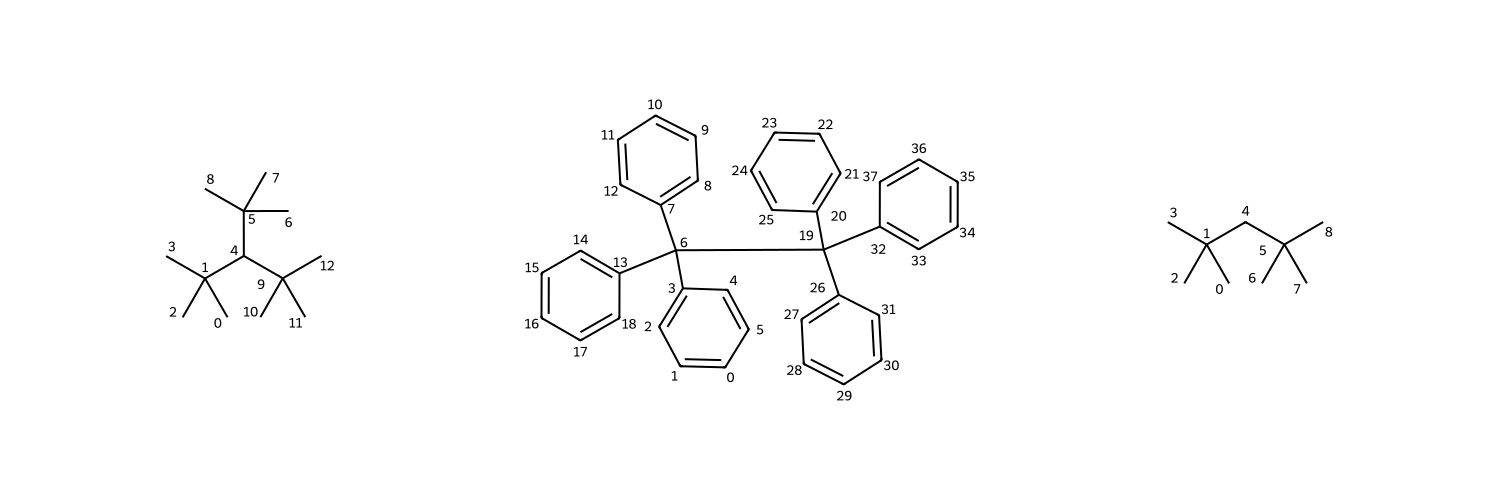

In [2]:
# smiles for tri-t-butylmethane,hexaphenylethane,2,2,4,4-tetramethylpentane
smiles = ['CC(C)(C)C(C(C)(C)C)C(C)(C)C','c1ccc(cc1)C(c2ccccc2)(c3ccccc3)C(c4ccccc4)(c5ccccc5)c6ccccc6','CC(C)(C)CC(C)(C)C']
# convert smiles to image grid
mols = [Chem.MolFromSmiles(s) for s in smiles]
# label atom index
for i,mol in enumerate(mols):
    for atom in mol.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))
    
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(500,500))
img

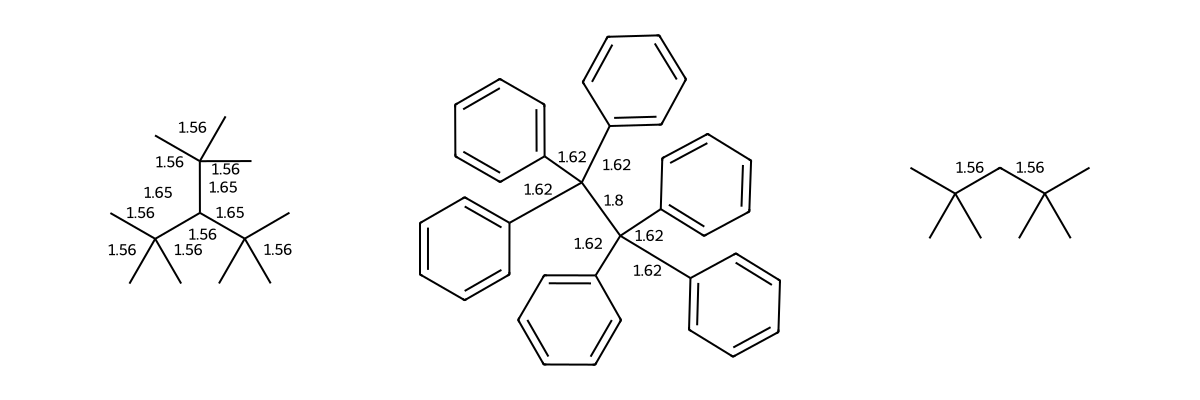

In [6]:
# optimize the mols using MMFF94
for i, m in enumerate(mols):
    # addHs
    m2d = m
    # clean atom index
    for atom in m.GetAtoms():
        atom.ClearProp('atomNote')
    m = Chem.AddHs(m)
    Chem.AllChem.EmbedMolecule(m)
    Chem.AllChem.MMFFOptimizeMolecule(m)
    # export the optimized mol to a xyz file
    conf = m.GetConformer()
    bond_length,img_bl,bond_idx = [],[],[]
    for x in m.GetBonds():
        # get bond index
        # get atom name of begin and end atom
        begin_atom = x.GetBeginAtom().GetSymbol()
        end_atom = x.GetEndAtom().GetSymbol()
        if begin_atom == 'C' and end_atom == 'C':
            bond_idx.append(x.GetIdx())
            bl = Chem.rdMolTransforms.GetBondLength(conf,x.GetBeginAtomIdx(),x.GetEndAtomIdx())
            bond_length.append(bl)
            img_bl.append(str(round(bl,2)))
    mols[i] = m2d
    d = rdMolDraw2D.MolDraw2DCairo(500,500)
    rdDepictor.Compute2DCoords(m2d)
    for n in range(len(img_bl)):
        if float(img_bl[n]) > 1.55:
            m2d.GetBondWithIdx(bond_idx[n]).SetProp('bondNote', img_bl[n])
    
    d.DrawMolecule(m2d)
    d.FinishDrawing()
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400,400))
img

In [7]:
#function to get bending angles
def bend_angle(smile,*args):
    angles = []
    m = Chem.MolFromSmiles(smile)
    m = Chem.AddHs(m)
    Chem.AllChem.EmbedMolecule(m)
    Chem.AllChem.MMFFOptimizeMolecule(m)
    conf = m.GetConformer()
    # get bending angles
    for i in args:
        angles.append(Chem.rdMolTransforms.GetAngleDeg(conf, i[0],i[1],i[2]))
    return angles


In [8]:
# tri-t-butylmethane bending angles. The args are the atom index of the three atoms shown in the image.
args = [(1,4,5),(4,5,8),(0,1,2)]
angles1 = bend_angle(smiles[0],*args)
print(f'tri-t-butylmethane bending angles: {angles1}')
# hexaphenylethane bending angles
args = [(3,6,19),(7,6,3),(32,19,20)]
angles2 = bend_angle(smiles[1],*args)
print(f'hexaphenylethane bending angles: {angles2}')
# 2,2,4,4-tetramethylpentane bending angles
args = [(1,4,5),(4,5,8),(0,1,2)]
angles3 = bend_angle(smiles[2],*args)
print(f'2,2,4,4-tetramethylpentane bending angles: {angles3}')

tri-t-butylmethane bending angles: [115.76880690866294, 114.25328540129958, 108.25260023812419]
hexaphenylethane bending angles: [116.57917658848496, 108.3475044257285, 108.34472860403767]
2,2,4,4-tetramethylpentane bending angles: [123.45792908518438, 106.92417745601414, 106.84634819096438]


### Problem 8 
(2) conformation analysis of 1-substituted cyclohexane using MMFF94

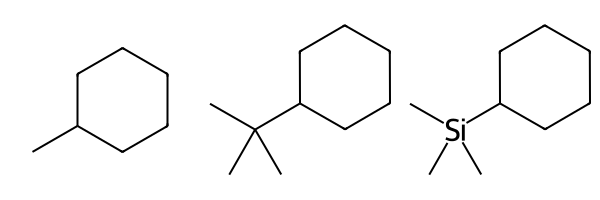

In [17]:
# 1-methylcyclohexane, 
smile = ['CC1CCCCC1','CC(C)(C)C1CCCCC1','C[Si](C)(C)C1CCCCC1']
mols = [Chem.MolFromSmiles(s) for s in smile]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200))
img

In [3]:
# generate lowest energy conformer based on MMFF94 force field
def generate_conformer(smiles, num_conformers=1000):
    mol = Chem.MolFromSmiles(smiles)  # Example molecule (ethanol)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers, params=AllChem.ETKDG())
    # Optimize and calculate energy for each conformer
    energies = []
    for confId in range(mol.GetNumConformers()):
        # Optimize the conformer
        AllChem.MMFFOptimizeMolecule(mol, confId=confId, mmffVariant='MMFF94')
        # Calculate the energy
        ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94'), confId=confId)
        energy = ff.CalcEnergy()
        energies.append([energy, confId])
    # Get the conformer with the lowest energy
    energies.sort(key=lambda x: x[0])
    # export the lowest energy conformer to a xyz file
    Chem.MolToXYZFile(mol, f'{smiles}.xyz', confId=energies[0][1])
    output = [energies[0]]
    for i in range(1,len(energies)):
        if energies[i][0] - energies[i-1][0] < 0.01:
            continue
        else:
            output.append(energies[i])
    return mol,output

In [49]:
mol1, energies1 = generate_conformer(smile[0])
mol2, energies2 = generate_conformer(smile[1])
mol3, energies3 = generate_conformer(smile[2])

In [76]:
# energy difference
print(f'1-methylcyclohexane energy difference: {energies1[0][0] - energies1[1][0]:.2f} kcal/mol')
print(f'1-tBucyclohexane energy difference: {energies2[0][0] - energies2[2][0]:.2f} kcal/mol')
print(f'1-TMS-cyclohexane energy difference: {energies3[0][0] - energies3[1][0]:.2f} kcal/mol')

1-methylcyclohexane energy difference: -1.37 kcal/mol
1-tBucyclohexane energy difference: -6.21 kcal/mol
1-TMS-cyclohexane energy difference: -2.04 kcal/mol


In [87]:
IPythonConsole.drawMol3D(mol1, confId=energies1[0][1])
IPythonConsole.drawMol3D(mol1, confId=energies1[1][1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [88]:
IPythonConsole.drawMol3D(mol2, confId=energies2[0][1])
IPythonConsole.drawMol3D(mol2, confId=energies2[2][1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [85]:
IPythonConsole.drawMol3D(mol3, confId=energies3[0][1])
IPythonConsole.drawMol3D(mol3, confId=energies3[1][1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Problem 9 : Build energy profile for butane rotation based on MMFF94 force field

In [53]:
# generate lowest energy conformer based on MMFF94 force field
def generate_conformer(smiles, num_conformers=100):
    mol = Chem.MolFromSmiles(smiles)  # Example molecule (ethanol)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers, params=AllChem.ETKDG())
    # Optimize and calculate energy for each conformer
    energies = []
    for confId in range(mol.GetNumConformers()):
        # Optimize the conformer
        AllChem.MMFFOptimizeMolecule(mol, confId=confId, mmffVariant='MMFF94')
        # Calculate the energy
        ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94'), confId=confId)
        energy = ff.CalcEnergy()
        energies.append(energy)
    # Get the conformer with the lowest energy
    lowest_energy_conf_id = energies.index(min(energies))
    lowest_energy_conf = mol.GetConformer(lowest_energy_conf_id)
    # export the optimized mol to a xyz file
    Chem.MolToXYZFile(mol, f'lowest_energy_conf.xyz',confId=lowest_energy_conf_id)
    return mol, lowest_energy_conf, lowest_energy_conf_id

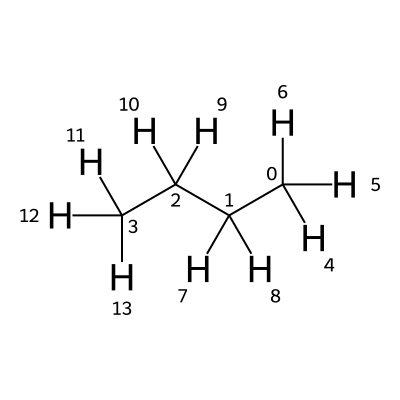

In [37]:
mol, conf, id = generate_conformer(smiles='CCCC')
# get the atom indices of the molecule
mol2d = Chem.MolFromSmiles('CCCC')
mol2d = Chem.AddHs(mol2d)
# show the molecule with atom index
d = rdMolDraw2D.MolDraw2DCairo(50,50)
rdDepictor.Compute2DCoords(mol2d)
for atom in mol2d.GetAtoms():
    atom.SetProp('atomNote', str(atom.GetIdx()))
d.DrawMolecule(mol2d)
# change figure size
d.FinishDrawing()
# Draw the molecule
Draw.MolToImage(mol2d, size=(400,400))

In [38]:
# visualize 3d
IPythonConsole.drawMol3D(mol, confId=id)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [39]:
# this is the butane conformers with different dihedral angle of 7,1,2,9
energies = []
degrees = []
for i in range(0,721,1):

    AllChem.MMFFOptimizeMolecule(mol, confId=id, mmffVariant='MMFF94')
    conf = mol.GetConformer(id)
    Chem.rdMolTransforms.SetDihedralDeg(conf, 7,1,2,9,i)
    
    mol.AddConformer(conf,assignId=True)
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s'), confId=100 + i)
    energy = ff.CalcEnergy()
    degrees.append(i)
    energies.append(energy)
    # export the optimized mol to a xyz file
    Chem.MolToXYZFile(mol, f'{i}.xyz',confId=100 + i)

Text(0, 0.5, 'MMFF energy(kcal/mol)')

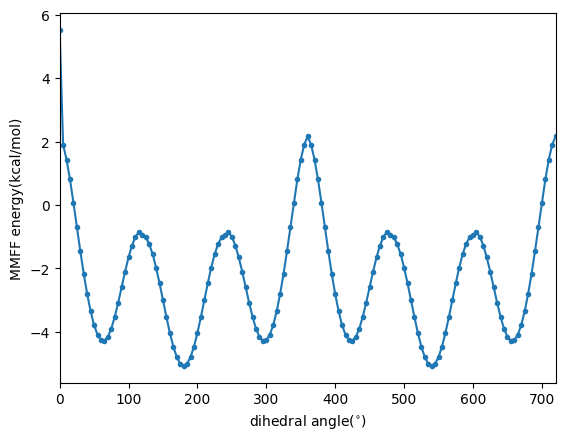

In [41]:
import matplotlib.pyplot as plt
plt.plot(degrees[::5],energies[::5],marker='.')
plt.xlim(0,720)
plt.xlabel('dihedral angle($^{\circ}$)')
plt.ylabel('MMFF energy(kcal/mol)')


In [51]:
# energy gap between anti and gauche
print(f'energy gap between anti and gauche: {energies[59] - energies[179]:.2f} kcal/mol')
# energy gap between gauche and eclipsed
print(f'energy gap between gauche and eclipsed: {energies[119] - energies[59]:.2f} kcal/mol')
# energy gap between gauche and synperiplanar
print(f'energy gap between gauche and synperiplanar: {energies[359] - energies[59]:.2f} kcal/mol')

energy gap between anti and gauche: 0.83 kcal/mol
energy gap between gauche and eclipsed: 3.42 kcal/mol
energy gap between gauche and synperiplanar: 6.37 kcal/mol
